In [1]:
import httpx
import asyncio
from fredapi import Fred
import requests
import numpy as np
import json
import pandas as pd
import pickle
import yahoo_fin.stock_info as si
# We use normal datetime for fred info and pandas datetime for data
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import islice
import math
import os
import matplotlib.pyplot as plt
from functools import lru_cache
from scipy.stats import hmean, trim_mean
from itertools import product
import sys
import cProfile
import yfinance as yf
import warnings
from collections import defaultdict

Get the list of elements

In [ ]:
comp = comp_load("PFE")
frame, unit = comp.fact("NetCashProvidedByUsedInOperatingActivities")
# print(frames,unit)
# frame.head()
# columns_to_load = ['name', 'documentation', 'balance','periodType','deprecatedLabel','deprecatedDate']
# # Load the CSV file
# df = pd.read_csv('frames\SecondListOfElements.csv', usecols=columns_to_load, encoding='latin1')
frame.to_csv("..\examples\Scramble.csv")
# print(comp.measures_and_dates)
# comp = comp_load("BLK")
# for motion, lists in comp.measures_and_dates.items():
#     for i in lists:
#         print(i)
# print(comp.fact("Assets", date_gather = True))

Find out what share methods companies use

In [ ]:
have = 0
total = 0
for ticker, availability in list(company_frames_availability.items())[:]:
    if availability[0] == "del":
        continue 
    (static, dynamic), yahoo = availability
    if (static  or dynamic):
        total +=1
        comp = comp_load(ticker)
        value = comp.data.get("EntityPublicFloat", False)
        if value:
            have +=1
        # else:
        #     value = comp.data.get("WeightedAverageNumberOfDilutedSharesOutstanding", False)
        #     if value:
        #         have +=1
        #     else:
        #         value = comp.data.get("EntityCommonStockSharesOutstanding", False)
        #         if value:
        #             have+=1
print(have/total)

Deprecated.

In [ ]:
dictionary = {}
tickers = ["META"]
for ticker in tickers:
    data = sync_companyfacts(ticker).json()
    data = data["facts"]["us-gaap"]
    for key,value in data.items():
        del value["units"]
        if not key in dictionary:
            dictionary[key] = value

with open("deprecated.json", "w")as file:
    json.dump(dictionary, file, indent= 1)
    file.close()

Get all the measure names

In [ ]:
ticker = "MSFT"
unit_list =[]
for ticker, availability in company_frames_availability.items():
    edgar, yahoo = availability
    if edgar and yahoo:
        with open(f"companies\{ticker}.pkl", "rb")as file:
            company = pickle.load(file)
            data = company.data
            compdict = {}
            for name,value in data.items():
                units = value["units"]
                unit_list += list(units.keys())

print(set(unit_list))

Plotting

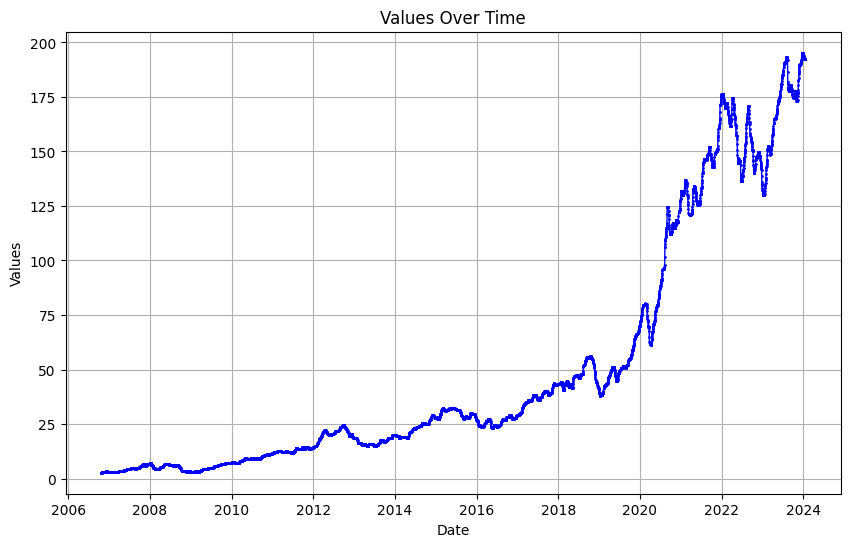

In [10]:
#   C:\Programming\Python\Finance\EDGAR\\ready_data\static\AAPL.csv
frame = pd.read_csv("C:\Programming\Python\Finance\EDGAR\clean_data\price\AAPL.csv", index_col=0, parse_dates=True)
plt.figure(figsize=(10, 6))
plt.plot(frame.index, frame['current_quantile'], marker='o', linestyle='-', color='b',markersize=1,linewidth=1)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Values Over Time')
plt.grid(True)
plt.show()

Correlation

In [9]:

mode = "dynamic"
first_fact = "GrossProfit" + "-0"
second_fact = "FreeCashFlow" + "-0"
def feature_correlation(first_fact, second_fact, mode):
    pearsons = []
    first_fact += "-0"
    second_fact += "-0"
    data_directory = f"..\\clean_data\{mode}"
    iterator = list(os.listdir(data_directory))
    for filename in iterator: #Iterates through the frames in the directory
        category_path = os.path.join(data_directory, filename) #Get the path to the frame
        internal_iterator = list(os.listdir(category_path))
        for filename in internal_iterator:
            file_path = os.path.join(category_path, filename)
            frame = pd.read_csv(file_path, index_col=0, parse_dates=True)
            frame.dropna(inplace=True)
            if not frame.empty:
                # print(filename)
                # covariance = frame[first_fact].cov(frame[second_fact])
                # print(f"covariance: {covariance}")
                # Pearson correlation
                if frame[first_fact].std() != 0 and frame[second_fact].std() != 0:
                    pearson_corr = frame[first_fact].corr(frame[second_fact])  # Defaults to Pearson
                    pearsons.append(pearson_corr)
                # print(f"    pearson_corr: {pearson_corr}")
                # Spearman correlation
                # spearman_corr = frame[first_fact].corr(frame[second_fact], method='spearman')
                # print(f"    spearman_corr: {spearman_corr}")
    fishers = []
    for r in pearsons:
        if r == 1:
            r = 0.99999
        elif r == -1:
            r = -0.99999
        fishers.append(0.5 * np.log((1 + r) / (1 - r)))
    # Handle cases with empty fishers list
    if fishers:
        average_transformed = trim_mean(fishers, 0.05)
        average_correlation = (np.exp(2 * average_transformed) - 1) / (np.exp(2 * average_transformed) + 1)
    else:
        average_correlation = np.nan  # Return NaN if no valid data
    return average_correlation

In [10]:
with open(r"..\other_pickle\measures.json", "r") as file:
    measures = json.load(file)
matrices = {}
for mode in ["dynamic", "static"]:
    corr_matrix = pd.DataFrame(index=measures[mode], columns=measures[mode], dtype=float)
    for col1 in measures[mode]:
        for col2 in measures[mode]:
            if pd.isnull(corr_matrix.at[col1, col2]):
                # Calculate correlation using custom function
                correlation = feature_correlation(col1, col2, mode)
                corr_matrix.at[col1, col2] = correlation
                corr_matrix.at[col2, col1] = correlation  # Ensure the matrix is symmetric
    matrices[mode] = corr_matrix
    # print(corr_matrix)
with open("..\other_pickle\\correlations.pkl") as file:
    pickle.dump(matrices,file)

FileNotFoundError: [Errno 2] No such file or directory: '..\\other_pickle\\correlations.pkl'

In [18]:
with open("..\other_pickle\\correlations.pkl", "wb") as file:
    pickle.dump(matrices,file)

In [30]:
for module in ["deap"]:
    if module in sys.modules:
        del sys.modules[module]
    import extract_functions
    from extract_functions import *

Evaluate the matrices 

In [67]:
import random
from deap import base, creator, tools, algorithms
# import deap
import numpy as np
with open(r"..\other_pickle\measures.json", "r") as file:
    measures = json.load(file)

# Objective function: Minimize sum of absolute correlations of selected features
def evaluate(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) < 2:
        return 100, 1 # High penalty for having less than two features
    submatrix = corr_matrix[np.ix_(selected_features, selected_features)]
    sum_abs_correlations = np.sum(np.abs(submatrix)) - len(selected_features)  # subtract self-correlations
    return (sum_abs_correlations, len(selected_features))

if hasattr(creator, 'FitnessMax'):
    del creator.FitnessMax  # Remove existing Fitness class

if hasattr(creator, 'FitnessMin'):
    del creator.FitnessMin  # Remove existing Fitness class

if hasattr(creator, 'Individual'):
    del creator.Individual  # Remove existing Individual class

# Set up genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1, 15))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(measures["static"]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selStochasticUniversalSampling)


In [69]:
# Run genetic algorithm
with open("..\other_pickle\\correlations.pkl", "rb") as file:
    matrices = pickle.load(file)
for mode in ["static"]:
    # Example correlation matrix (replace with your actual matrix)
    corr_matrix = matrices[mode].values  # 10 features with correlations between -0.5 and 0.5
    population = toolbox.population(n=300)
    result = algorithms.eaSimple(population, toolbox, cxpb=0.6, mutpb=0.2, ngen=10, verbose=False)
    best_ind = tools.selBest(population, 10)
    for ind in best_ind:
        print("Best individual is:", ind)
        print("Selected features:", [i for i, bit in enumerate(ind) if bit == 1])
        print("Fitness (Total Absolute Correlation):", ind.fitness.values)


Best individual is: [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Selected features: [2, 4, 5, 6, 7, 10]
Fitness (Total Absolute Correlation): (18.77016676747398, 6.0)
Best individual is: [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Selected features: [0, 1, 4, 5, 6, 9, 12]
Fitness (Total Absolute Correlation): (22.257134386031762, 7.0)
Best individual is: [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Selected features: [0, 2, 3, 6, 7, 9]
Fitness (Total Absolute Correlation): (22.396873620797503, 6.0)
Best individual is: [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Selected features: [0, 2, 4, 7, 8, 9, 12]
Fitness (Total Absolute Correlation): (22.89874252976968, 7.0)
Best individual is: [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1]
Selected features: [0, 2, 5, 7, 8, 10, 12]
Fitness (Total Absolute Correlation): (25.465665218110146, 7.0)
Best individual is: [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]
Selected features: [0, 2, 4, 6, 7, 10, 12]
Fitness (Total Absolute Correlation): (25.53403941342377, 7.0)
Best individ

In [10]:
matrices["static"].to_csv("..\examples\\matrix.csv")